hog(histogram of oriented gradient, 方向梯度直方图)，提取图像特征，去除冗余特征。一般与SVM等分类器结合，提升分类精度。其原理是提取物体的边缘特征，即轮廓信息，类似于一种压缩，并将轮廓信息转化为一维向量，从而输入后续SVM等分类器进行训练。在深度学习兴起之前，hog特征应用广泛。

原始图像如下所示，宽高为100x200.
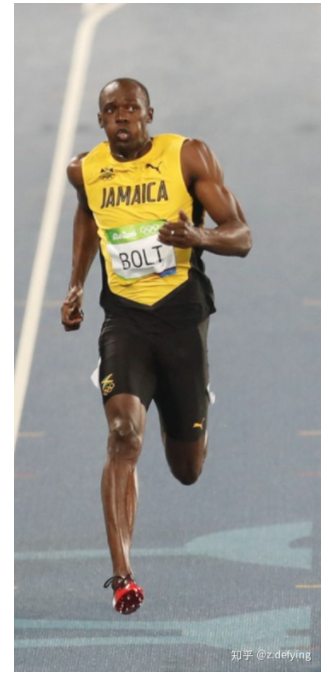

计算hog特征描述符的计算步骤：<br/>
1.图像预处理：可以对图像进行裁剪，并缩放到固定尺寸。灰度图像是可选操作，对于RGB图像，先对三通道分别计算梯度，然后取最大梯度值。<br/>
然后进行伽马校正，以减少光照对图像的影响，使得过曝光或欠曝光的图像恢复正常。伽马校正如下：
$$
f(x) = x^{\gamma}
$$

In [3]:
#实现如下：
import cv2
import numpy as np
img = cv2.imread(r'C:\Users\dell\Desktop\girl.jpg', 0)
img2 = np.power(img/float(np.max(img)), 1.5)

2.计算梯度图：计算水平与垂直梯度，梯度的计算如下所示，对于下图中的白色的圆，从左至右计算水平梯度，即像素差值，当移动到圆的边缘时，梯度值较大，同理，从上至下计算垂直方向梯度。
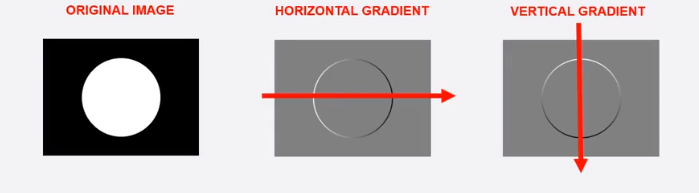

具体计算过程如下所示，假设要计算红色像素点的梯度，用120-70得到水平梯度，100-50得到垂直方向梯度，然后计算梯度幅值$\sqrt(50^2 + 50^2) = 70.1$，及梯度方向 $arctan(g_y / g_x) = arctan(50/50) = 45度$,如红色箭头所示
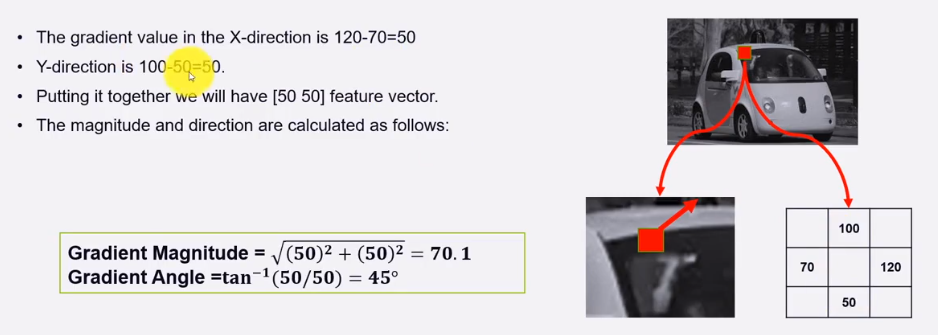

在实现时，可以通过以下sobel算子来实现：
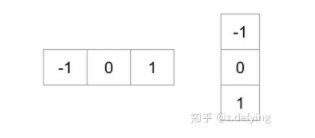

In [4]:
#代码如下:
import cv2
import numpy as np

# Read image
img = cv2.imread(r'C:\Users\dell\Desktop\girl.jpg')
img = np.float32(img) / 255.0  # 归一化

# 计算x和y方向的梯度
gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)

# 计算合梯度的幅值和方向（角度）
mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

3.计算梯度直方图：先把整个图像划分为若干个8x8的小单元，称为cell，并计算每个cell的梯度直方图。这个cell的尺寸也可以是其他值，根据具体的特征而定。<br/>
因为对于一整张梯度图，其中的有效特征是非常稀疏的，不但运算量大，而且效果可能还不好。于是我们就使用特征描述符来表示一个更紧凑的特征。一个8x8的小单元就包含了8x8x2 = 128个值，因为每个像素包括梯度的大小和方向。<br/>
我们要把这个8x8的小单元用长度为9的数组来表示，这种表示方法不仅使得特征更加紧凑，而且对单个像素值的变化不敏感，也就是能够抗噪声干扰。<br/>
一个cell中的梯度如下：
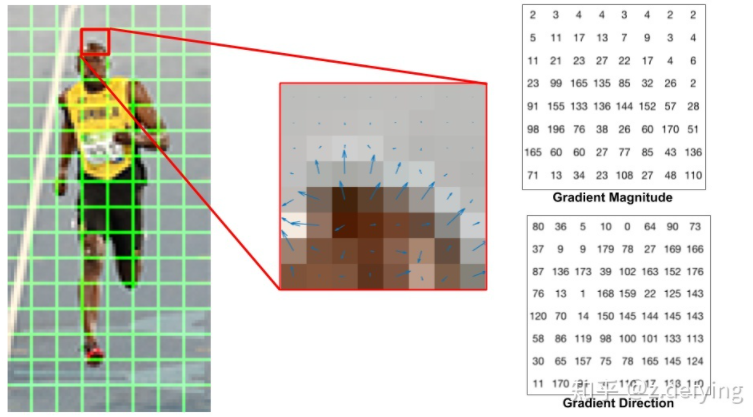

现在我们来计算cell中像素的梯度直方图，先将角度范围分成9份，也就是9 bins，每20°为一个单元，也就是这些像素可以根据角度分为9组。将每一份中所有像素对应的梯度值进行累加，可以得到9个数值。直方图就是由这9个数值组成的数组，对应于角度0、20、40、60... 160。
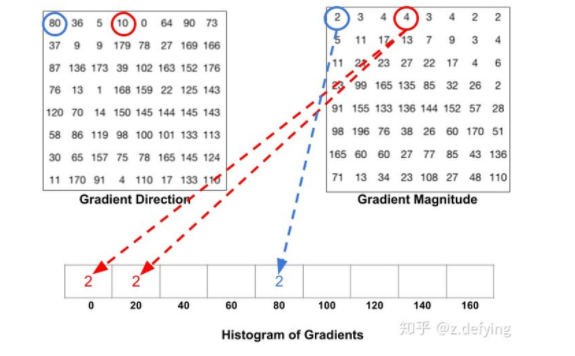

化成直方图的形式如下;
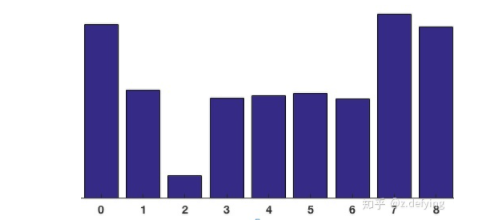

4.Block 归一化:HOG将8×8的一个区域作为一个cell，再以2×2个cell作为一组，称为block。由于每个cell有9个值，2×2个cell则有36个值，HOG是通过滑动窗口的方式来得到block的，如下图所示：
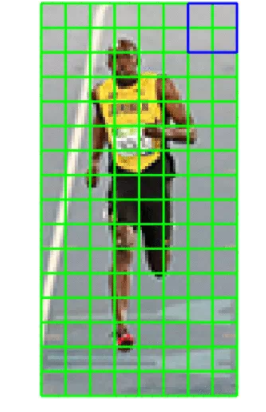

在前面的步骤中，我们基于图像的梯度对每个cell创建了一个直方图。<br/>
但是图像的梯度对整体光照非常敏感，比如通过将所有像素值除以2来使图像变暗，那么梯度幅值将减小一半，因此直方图中的值也将减小一半。 理想情况下，我们希望我们的特征描述符不会受到光照变化的影响，那么我们就需要将直方图“归一化”。<br/>
一个block有4个直方图，将这4个直方图拼接成长度为36的向量，然后对这个向量进行归一化。

5.计算HOG特征向量(特征描述符):比如上面这个图，将整幅图像划分成cell的个数为8x16，就是横向有8个cell，纵向有16个cell。每个block有2x2个cell的话，那么cell的个数为：(16-1)x(8-1)=105。即有7个水平block和15个竖直block。<br/>
再将这105个block合并，就得到了整个图像的特征描述符，长度为 105×36=3780。

In [ ]:
#实现
from skimage import feature, exposure
import cv2
image = cv2.imread(r'C:\Users\dell\Desktop\girl.jpg')
fd, hog_image = feature.hog(image, orientations=9, pixels_per_cell=(16, 16),
                    cells_per_block=(2, 2), visualize=True)

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

cv2.imshow('img', image)
cv2.imshow('hog', hog_image_rescaled)
cv2.waitKey(0)==ord('q')

效果如下：
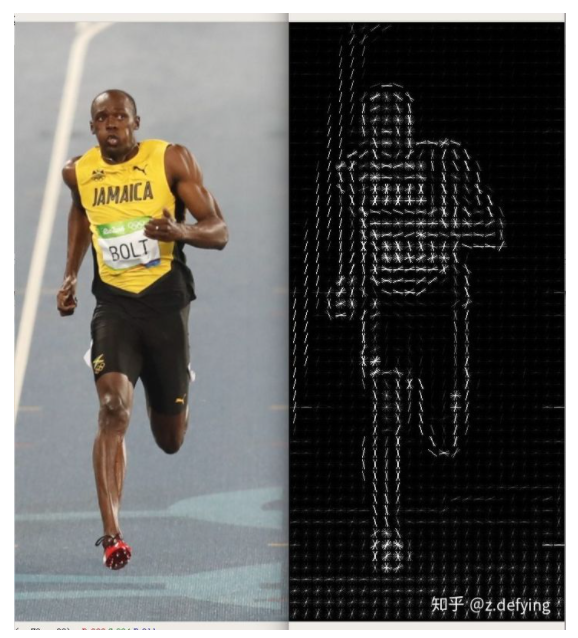